<img src="escudo_utfsm.gif" style="float:right;height:100px">
<img src="IsotipoDIisocolor.png" style="float:left;height:100px">
<center>
    <h1> ILI285 - Computación Científica I / INF285 - Computación Científica</h1>
    <h1> Tarea 4: PageRank y GMRes </h1>
    <h2> Alejandro Vilches Cornejo 201573554-9</h2>
    <h2> alejandro.vilches@sansano.usm.cl</h2>
    <h3> [S]cientific [C]omputing [T]eam 2019</h3>
</center>
<p>
<center>Julio 2019 - v1.3 </center>
</p>

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy as sp
from ipywidgets import interact, IntSlider
#if not instaled: pip3 install networkx
import networkx as nx
import math
from time import time

## Contexto

Con el rápido crecimiento de internet, los motores de búsqueda en la web se han convertido en importantes herramientas para obtener información. Google es uno de los más exitosos y populares sistemas en estos años, dado su simple algoritmo, [PageRank](https://en.wikipedia.org/wiki/PageRank), el cual fue propuesto por _Larry Page_ y _Sergey Brin_. PageRank busca asignar de forma numérica la relevancia de las páginas web basándose en la cantidad de los enlaces que apuntan hacia ella.

En esta tarea se utilizará el algoritmo de PageRank para encontrar páginas web relevantes a partir de información relaciones entre los links o enlaces entre varias páginas.

## PageRank

Para poder trabajar con el algoritmo, es necesario considerar inicialmente una matriz de adyacencia $A \in \mathbb{R}^{n \times n}$, con $n$ la cantidad de páginas web. Las entradas $a_{ij}$ de esta matriz tienen el valor 1 si la página $i$ tiene un enlace a la página $j$ y 0 en caso contrario. Notar que no necesariamente la matriz $A$ es simétrica, lo que denota que dos páginas web distintas podrían no enlazarse mutuamente. Además, considere que una misma página no se enlazará consigo misma, por lo que la matriz tendrá cero en su diagonal principal. 

Adicionalmente, podrían darse casos de que existan páginas que solo tienen links hacia ellas, pero no tienen links hacia otras páginas. En una representación de la matriz de adyacencia como grafo, se le conoce a estas páginas como nodos _sumideros_. Una consecuencia de estos casos podía ser que usuarios que llegan a esas páginas quedan retenidos porque no existen links a los cuales seguir navegando. Para evitar esta situación, se agregará la perturbación _rank-one_ a la matriz de adyacencia $A$.

$$
    \tilde{A} = A + \mathbf{a}\cdot\mathbf{1}^T,
$$

donde $\mathbf{a} \in \mathbb{R}^{n}$ es un vector con un $1$ en la componente que corresponde a los nodos sumideros  y $0$ en los otras componentes, el vector $\mathbf{1}$ corresponde al vector de unos en $\mathbb{R}^{n}$ y $^T$ es el operador transpuesta.


Considere la siguiente matriz de adyacencia que muestra la relación entre 5 páginas web.

$$
A = \begin{bmatrix}
0 & 1 & 1 & 0 & 0\\
0 & 0 & 1 & 1 & 0\\
1 & 1 & 0 & 1 & 1\\
0 & 0 & 0 & 0 & 0\\
1 & 0 & 1 & 1 & 0\\
\end{bmatrix}
$$

In [2]:
#generacion de una matriz aleatoria
np.random.seed(2564)
A = np.random.randint(2, size=(5,5))
#eliminar diagonales en caso de existir alguna
np.fill_diagonal(A,0)
print(A)

[[0 1 1 0 0]
 [0 0 1 1 0]
 [1 1 0 1 1]
 [0 0 0 0 0]
 [1 0 1 1 0]]


In [4]:
def draw_adjacency_matrix(A):
    n = A.shape[0]
    G = nx.DiGraph()
    edges = list()
    for i in range(n):
        for j in range(n):
            if A[i,j] > 0:
                edges.append((i,j))
    G.add_nodes_from(range(n))
    G.add_edges_from(edges)
    nx.draw(G, with_labels=True, font_weight='bold', arrows=True, arrowsize = 30, alpha=0.5)
    plt.show()

La matriz puede ser visualizada en forma de gráfo dirigido con la función `draw_adjacency_matrix(A)`

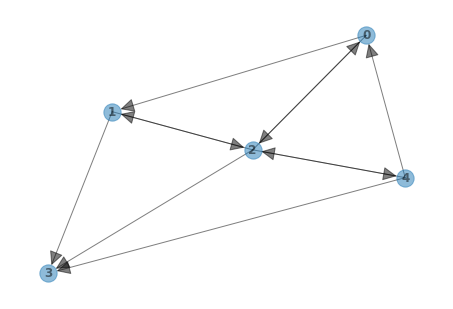

In [5]:
draw_adjacency_matrix(A)

En este caso el nodo 3 es un nodo _sumidero_ por lo que agregando la perturbación mostrada anteriormente, la matriz $\tilde{A}$ quedaría como:

$$
\tilde{A} = \begin{bmatrix}
0 & 1 & 1 & 0 & 0\\
0 & 0 & 1 & 1 & 0\\
1 & 1 & 0 & 1 & 1\\
1 & 1 & 1 & 1 & 1\\
1 & 0 & 1 & 1 & 0\\
\end{bmatrix}
$$

In [6]:
A_tilde = A + np.outer(np.array([0,0,0,1,0]),np.ones(5))
print(A_tilde)

[[0. 1. 1. 0. 0.]
 [0. 0. 1. 1. 0.]
 [1. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 0.]]


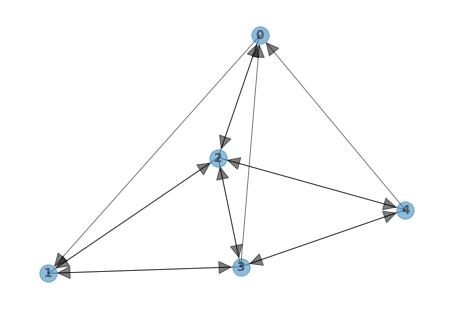

In [7]:
draw_adjacency_matrix(A_tilde)

Una vez establecida la matriz de adyacencia (con perturbaciones si aplica), dos fenómenos deben considerarse:

**1.** Considere que las páginas son navegadas al azar, en un proceso llamado _random walk_. Esto es, que una página $j$ puede ser accedida por cualquier otra página $i$ que posea un enlace hacia ella con la misma probabilidad. Sea $p_{ij}$ la probabilidad de visitar la página $j$ a partir de $i$. Cada valor de $p_{ij}$ corresponde a las entradas de una matriz de transición $P$, la cual es **estocástica por filas**, esto es, que todas sus filas cumplen la propiedad de que la suma de sus valores es igual a 1. De acuerdo al ejemplo anterior, la matriz $P$ se obtiene dividiendo cada fila por la suma de sus valores:

$$
P = \begin{bmatrix}
0   & 1/2 & 1/2 & 0   & 0\\
0   & 0   & 1/2 & 1/2 & 0\\
1/4 & 1/4 & 0   & 1/4 & 1/4\\
1/5 & 1/5 & 1/5 & 1/5 & 1/5\\
1/3 & 0   & 1/3 & 1/3 & 0\\
\end{bmatrix}
$$

**2.** Se debe considerar, además del _random walk_, el evento aleatorio de saltar desde una página $i$ a cualquier otra página no necesariamente adyacente en el grafo. Este comportamiento es el _random jump_ o _teleport_, y le es asociado a un vector $\mathbf{v} \in \mathbb{R}^n$, tal que $\mathbf{v} = \mathbf{e}/n$, $\mathbf{e} = \begin{bmatrix}1 & 1 & \ldots & 1 & 1 \end{bmatrix}^T$ es un vector de unos que asigna la misma ponderación de probabilidad de _salto_ a todas las $n$ páginas en el grafo.

Se define $G \in \mathbb{R}^{n \times n}$ la **Matriz de Google** que considera los dos fenómenos descritos anteriormente, donde se ha incorporado un factor de amortiguamiento (_damping factor_) $\alpha$.

$$
G = \alpha\,P^T + (1-\alpha)\,\mathbf{v}\mathbf{e}^T
$$

La matriz $G$ es estocástica por columnas y tiene la propiedad de que su mayor valor propio en magnitud, que se conoce como valor propio dominante, es igual a 1. El cálculo de PageRank consiste en determinar el vector propio $\mathbf{x}$ que está asociado a este valor propio dominante, es decir: 

$$
\mathbf{x} = G\,\mathbf{x}
$$

El vector propio $\mathbf{x}$ puede normalizarse (debido a que cualquier múltiplo de $\mathbf{x}$ también es vector propio), de tal forma que los valores de este vector representan probabilidades. Al considerar las probabilidades, de mayor a menor, se establece un ranking de páginas que serán mostradas por el motor de búsqueda de Google. 

Usualmente, se pueden utilizar métodos numéricos que estimen este vector $\mathbf{x}$, pero suelen ser costosos y converger muy lento. Es por esto, que una versión alternativa para encontrar PageRank considera resolver un sistema de ecuaciones. Combinando las ecuaciones anteriores y reordenando se tiene que:

$$
\begin{aligned}
\mathbf{x} &= \left( \alpha\,P^T + (1-\alpha)\,\mathbf{v}\mathbf{e}^T \right)\,\mathbf{x}\\
\mathbf{x}-\alpha\,P^T\,\mathbf{x} &= (1-\alpha)\,\mathbf{v}\mathbf{e}^T\mathbf{x}\\
\end{aligned}
$$

Debido a que $\mathbf{x}$ está normalizado, $\mathbf{e}^T\mathbf{x} = 1$ y se debe resolver el siguiente sistema lineal:

$$
\begin{aligned}
(I-\alpha\,P^T)\mathbf{x} &= (1-\alpha)\,\mathbf{v}\\
\widehat{A}\,\mathbf{x} &= \widehat{\mathbf{b}}
\end{aligned}
$$

En el cual, la matriz $\widehat{A} \in \mathbb{R}^{n \times n}$ es una matriz dispersa, no necesariamente simétrica y $\widehat{\mathbf{b}} \in \mathbb{R}^n$. Debido a las propiedades de la matriz $\widehat{A}$, en esta tarea se estudiará el uso de GMRes para resolver este tipo de sistemas lineales. Para poder interpretar las soluciones de PageRank como probabilidades, el vector de soluciones $\mathbf{x}$ debe normalizarse de manera que sus elementos sumen 1, i.e, $\mathbf{\tilde{x}} = \mathbf{x}/\|\mathbf{x}\|_1$.

### Datasets

Considere los datasets de los archivos `adjacency1.dat`, `adjacency2.dat`, `adjacency3.dat` y `adjacency4.dat`, que representan matrices de adyacencia tales que:
- Adjacency1 es una matriz de adyacencia de 100 páginas y alrededor de un 20% de elementos no nulos.
- Adjacency2 es una matriz de adyacencia de 100 páginas y alrededor de un 50% de elementos no nulos.
- Adjacency3 es una matriz de adyacencia de 100 páginas y alrededor de un 80% de elementos no nulos.
- Adjacency4 es una matriz de adyacencia de 1000 páginas y alrededor de un 5% de elementos no nulos.

Cada fila $i$ de un archivo dataset corresponde a una página de índice $i$, y todos los valores separados por espacios en dicha fila representan los índices de las páginas $j$ a las cuales $i$ apunta. En otras palabras, un archivo dataset registra los vértices del grafo de adyacencia.

Considere la siguiente función,`read_adjacency_matrix` , que obtiene la matriz de adyacencia a partir de los archivos anteriores.

In [8]:
'''
Input:
filename - (string) name of adjacency matrix file
Output: 
A - (n x n matrix) adjacency matrix
'''
def read_adjacency_matrix(file_path):
    adjacency_list = []
    with open(file_path, 'r') as f:
        for line in f:
            adjacency_list.append(np.array(list(map(int, line.split()))))
    n = len(adjacency_list)
    A = np.zeros((n,n))
    for i in range(n):
        A[i, adjacency_list[i]] = 1
    return A

In [9]:
A = read_adjacency_matrix("adjacency1.dat")
print(A)

[[0. 0. 1. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 1. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 1.]
 [1. 0. 0. ... 1. 0. 0.]]


Considere además, el dataset `web-NotreDame` un dataset compuesto por 325729 páginas y 1497134 links entre ellas y el dataset `web-Stanford` compuesto por 281903 páginas y 2312497 links. Estos datasets se encuentran disponibles en los siguientes links. 

- <a href="http://snap.stanford.edu/data/web-NotreDame.html"> Dataset NotreDame</a> [2]
- <a href="http://snap.stanford.edu/data/web-Stanford.html">Dataset Stanford</a> [3]

## Sección 1 (30 puntos): Comparación de soluciones con GMRes y PALU

En esta sección se compararán las soluciones de PageRank obtenidas por medio de GMRes y PALU. Para esto, se considerarán los datasets de los archivos `adjacency1.dat`, `adjacency2.dat`, `adjacency3.dat` y `adjacency4.dat`, variaciones en el _damping factor_ $\alpha$ y el número de iteraciones $k$ de GMRes.

**1.** Construya el sistema lineal necesario para encontrar PageRank. Para ello desarrolle la función `build_linear_system`, que recibe una matriz de adyacencia $A$ y un _damping factor_ $\alpha$.

```python
'''
Input:
A - (n x n matrix) adjacency matrix
alpha - (float) damping factor, takes values from 0 to 1
Output: 
A_hat - (n x n matrix) matrix of linear system
b_hat - (n vector) right hand side vector of linear system
'''
def build_linear_system(A, alpha):
    ...
    return A_hat, b_hat
```

In [10]:
def build_linear_system(A, alpha):
    #Creacion de la matriz Ã
    
    n = len(A)
    
    a = np.zeros(n)
    
    for i in range(n):
        if(sum(A[i]) == 0):
            a[i] = 1
    
    A_tilde = P = A + np.outer(a,np.ones(n))
    
    #obtencion de la matriz de prob P
    
    for i in range(n):
        s = sum(P[i])
        P[i] = list(map(lambda x: x/s, P[i]))
    
    #obtencion de los elementos del sistema
    
    e = np.transpose(np.ones(n))
    v = list(map(lambda x: x/n, e))
    I = np.identity(n) #identidad de nxn
    
    aPt = np.transpose(P)
    
    for i in range(n):
        aPt[i] = list(map(lambda x: x*alpha, aPt[i]))
    
    A_hat = I - aPt
    b_hat = list(map(lambda x: (1-alpha)*x, v))
    
    return A_hat, b_hat

**2.** Considere el error $e_k = \|\mathbf{x^{k}_{G}}-\mathbf{x_{P}}\|_2$ una métrica de error que compara $\mathbf{x_{P}}$, la solución de PageRank obtenida por PALU, con $\mathbf{x^{k}_{G}}$ la solución de PageRank obtenida con $k$ iteraciones de GMRes. Construya un gráfico que muestre $e_k$ versus $k$ y utilice un widget para seleccionar un dataset y variar el valor del _damping factor_ $\alpha$. ¿Qué puede decir de la información mostrada en el gráfico? ¿Cómo afecta $\alpha$ en los resultados obtenidos?

## PALU

In [11]:
#Codigo para el desarrollo de PALU, obtenido del github del ramo 
#(https://github.com/tclaudioe/Scientific-Computing/blob/master/SC1/05_linear_systems_of_equations.ipynb)

#permutation between rows i and j on matrix A
def row_perm(A, i, j):
    tmp = np.copy(A[i])
    A[i] = A[j]
    A[j] = tmp
    
def solve_triangular(A, b, upper=True):
    n = b.shape[0]
    x = np.zeros_like(b)
    if upper==True:
        #perform back-substitution
        x[-1] = (1./A[-1,-1]) * b[-1]
        for i in range(n-2, -1, -1):
            x[i] = (1./A[i,i]) * (b[i] - np.sum(A[i,i+1:] * x[i+1:]))
    else:
        #perform forward-substitution
        x[0] = (1./A[0,0]) * b[0]
        for i in range(1,n):
            x[i] = (1./A[i,i]) * (b[i] - np.sum(A[i,:i] * x[:i]))
    return x

def palu_decomp(A, show=False):
    N,_ = A.shape
    P = np.identity(N)
    L = np.zeros((N,N))
    U = np.copy(A)
    if show:
        print('Initial matrices')
        print('P = '); print(np.array_str(P, precision=2, suppress_small=True))
        print('L = '); print(np.array_str(L, precision=2, suppress_small=True))
        print('U = '); print(np.array_str(U, precision=2, suppress_small=True))
        print('----------------------------------------')
    #iterating through columns
    for j in range(N-1):
        #determine the new pivot
        p_index = np.argmax(np.abs(U[j:,j]))
        if p_index != 0:
            row_perm(P, j, j+p_index)
            row_perm(U, j, j+p_index)
            row_perm(L, j, j+p_index)
            if show:
                print('A permutation has been made')
                print('P = '); print(np.array_str(P, precision=2, suppress_small=True))
                print('L = '); print(np.array_str(L, precision=2, suppress_small=True))
                print('U = '); print(np.array_str(U, precision=2, suppress_small=True))
                print('----------------------------------------')
        #iterating through rows
        for i in range(j+1,N):
            L[i,j] = U[i,j]/U[j,j]
            U[i] -= L[i,j]*U[j]
            if show:
                print('P = '); print(np.array_str(P, precision=2, suppress_small=True))
                print('L = '); print(np.array_str(L, precision=2, suppress_small=True))
                print('U = '); print(np.array_str(U, precision=2, suppress_small=True))
                print('----------------------------------------')
    np.fill_diagonal(L,1)
    return P,L,U

def solve_palu(A, b, show=False):
    P,L,U = palu_decomp(A, show)
    #A.x = b -> P.A.x = P.b = b'
    b = np.dot(P,b)
    # L.c = b' with c = U.x
    c = solve_triangular(L, b, upper=False)
    x = solve_triangular(U, c)
    return x

## GMRes

In [13]:
#Codigo para el desarrollo de GMRes, obtenido del github del ramo
#https://github.com/tclaudioe/Scientific-Computing/blob/master/SC1/10_GMRes.ipynb
# This is a very instructive implementation of GMRes.
def GMRes(A, b, x0=np.array([0.0]), m=10, flag_display=False, threshold=1e-12):
    n = len(b)
    if len(x0)==1:
        x0=np.zeros(n)
    r0 = b - np.dot(A, x0)
    nr0=np.linalg.norm(r0)
    out_res=np.array(nr0)
    Q = np.zeros((n,n))
    H = np.zeros((n,n))
    Q[:,0] = r0 / nr0
    flag_break=False
    for k in np.arange(np.min((m,n))):
        y = np.dot(A, Q[:,k])
        if flag_display:
            print('||y||=',np.linalg.norm(y))
        for j in np.arange(k+1):
            H[j][k] = np.dot(Q[:,j], y)
            if flag_display:
                print('H[',j,'][',k,']=',H[j][k])
            y = y - np.dot(H[j][k],Q[:,j])
            if flag_display:
                print('||y||=',np.linalg.norm(y))
        # All but the last equation are treated equally. Why?
        if k+1<n:
            H[k+1][k] = np.linalg.norm(y)
            if flag_display:
                print('H[',k+1,'][',k,']=',H[k+1][k])
            if (np.abs(H[k+1][k]) > 1e-16):
                Q[:,k+1] = y/H[k+1][k]
            else:
                print('flag_break has been activated')
                flag_break=True
            # Do you remember e_1? The canonical vector.
            e1 = np.zeros((k+1)+1)        
            e1[0]=1
            H_tilde=H[0:(k+1)+1,0:k+1]
        else:
            H_tilde=H[0:k+1,0:k+1]
        # Solving the 'SMALL' least square problem. 
        # This could be improved with Givens rotations!
        ck = np.linalg.lstsq(H_tilde, nr0*e1)[0] 
        if k+1<n:
            x = x0 + np.dot(Q[:,0:(k+1)], ck)
        else:
            x = x0 + np.dot(Q, ck)
        # Why is 'norm_small' equal to 'norm_full'?
        norm_small=np.linalg.norm(np.dot(H_tilde,ck)-nr0*e1)
        out_res = np.append(out_res,norm_small)
        if flag_display:
            norm_full=np.linalg.norm(b-np.dot(A,x))
            print('..........||b-A\,x_k||=',norm_full)
            print('..........||H_k\,c_k-nr0*e1||',norm_small);
        if flag_break:
            if flag_display: 
                print('EXIT: flag_break=True')
            break
        if norm_small<threshold:
            if flag_display:
                print('EXIT: norm_small<threshold')
            break
    return x,out_res

## Grafico comparativo de Ek vs k

In [15]:
def plot_error_GMRvsPALU(data_set = "adjacency1.dat", alpha = 0.85, k = 10):
    A = read_adjacency_matrix(data_set)
    A_hat, b_hat = build_linear_system(A, alpha)
    
    xp = solve_palu(A_hat, b_hat)
    xp = list(map(lambda x: x/np.linalg.norm(xp,1), xp))
    
    y_k = np.arange(1,k+1)
    ek = []

    for i in range(1, k+1):
        x_our, _ = GMRes(A_hat, b_hat, m = i)
        ek.append(np.linalg.norm(x_our - xp))
    
    plt.figure(figsize=(8,8))
    plt.plot(y_k,ek,'b-',label='ek')
    plt.legend(loc='best')
    plt.title('Comparación de la solucion obtenida por GMRes vs PALU')
    plt.grid(True)
    plt.show()
    
interact(plot_error_GMRvsPALU, data_set = ["adjacency1.dat", "adjacency2.dat", "adjacency3.dat", "adjacency4.dat"], 
         alpha = (0,1,0.05), k = (1,100,10))

interactive(children=(Dropdown(description='data_set', options=('adjacency1.dat', 'adjacency2.dat', 'adjacency3.dat', 'adjacency4.dat'), value='adjacency1.dat'), FloatSlider(value=0.85, description='alpha', max=1.0, step=0.05), IntSlider(value=10, description='k', min=1, step=10), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_error_GMRvsPALU>

## Análisis Resultados:

Como podemos ver, el grafico anterior muestra la variación del error entre el resultado de GMRes y PALU con respecto a las iteraciones usadas en GMRes. Como es sabido, la solución para PALU solo depende del valor de $\alpha$ que se este usando, ya que este genera cambios en el sistema a resolver. Asi, si se fija un valor de $\alpha = 0.85$ para ambos metodos, con el fin de resolver el mismo sistema en ambos casos, se tiene que la solución de PALU sera siempre la misma y solo cambiará la solución de GMRes segun el número de iteraciones, es asi como un mayor número de iteraciones genera que la solución de GMRes sea cada vez mas cercana a la real, y a su vez cada vez mas cercana a lo que obtiene PALU, por lo que el comportamiento que posee el gráfico es esperado, ya que a medida que se aumentan las iteraciones, la diferencia entre la solución de GMRes y PALU se hace aproximadamente $0$.

Con respecto a los cambios que genera $\alpha$ en las soluciones, es necesario primero que todo recordar que significa este valor y en que influye dentro del sistema. Para cada valor de $\alpha$ se genera un nuevo sistema de ecuaciones a resolver, ya que la matriz $G$ cambiara segun el valor de este. En palabras simples, el valor que tome $\alpha$ generara un sistema de ecuaciones donde se le otorga mas importancia a los saltos estocasticos (matriz $P$) o uno donde se privilengian los saltos random (random walk). Así, un valor mas cercano a 1 de $\alpha$ nos otorga un sistema enfocado en los saltos estocasticos, por lo que la solución al PageRank será mas distribuida, generando paginas con una alta mayor probabilidad de ser visitadas que otras. En cambio si se el valor de $\alpha$ es cercano a 0, el sistema dará privilegio a los saltos random, lo cual se vera reflejado en la solución como un PageRank donde todas las paginas tienen aproximadamente la misma probabilidad de ser visitadas, dado que se privilegia los saltos randoms entre estas.

## Sección 2 (30 puntos): Tiempo de Ejecución

En esta sección se compararán los tiempos de ejecución de GMRes y PALU necesarios para resolver los sistemas de ecuaciones de PageRank. Para esto, se considerarán los datasets de los archivos `adjacency1.dat`, `adjacency2.dat`, `adjacency3.dat` y `adjacency4.dat`, variaciones en el _damping factor_ $\alpha$ y el número de iteraciones $k$ de GMRes.

**1.** Analice efecto de variar _damping factor_ $\alpha$ para encontrar las 10 primeras páginas entregadas por PageRank. Para ello utilice la función `get_damping_ranking` definida a continuación. 

```python
'''
Input:
A - (n x n matrix) adjacency matrix
alpha - (float) damping factor, takes values from 0 to 1
k - number of iterations of GMRes until return a solution, use only if method is 'GMRes'
method - string that indicates the method used to solve the linear system. Take values 'PALU' or 'GMRes'
Output: 
ranking - list with 10 pages of ranking sorted by largest probability
'''
def get_damping_ranking(A, alpha, k, method='GMRes'):
    ...
    return ranking
```

In [18]:
def get_damping_ranking(A, alpha, k, method='GMRes'):
    #your code goes here!
    
    ranking = []
    
    A_hat, b_hat = build_linear_system(A, alpha)
    
    if(method == "GMRes"):
        ranking, _ = GMRes(A_hat, b_hat, m = k)
        
    else:
        ranking = solve_palu(A_hat, b_hat)
    
    ranking = np.sort(ranking)
    ranking = np.flip(ranking, axis=0)
        
    return ranking[0:10]

#El siguiente codigo puede ser sujeto a cambios si desea ver otras soluciones, se utilizo para conocer el comportamiento 
#de la solucion segun los cambios que provocaba la variacion de a los valores en estudio.

A = read_adjacency_matrix('adjacency3.dat') 
sol = get_damping_ranking(A, 0.1, 10, method='GMRes') 
print(sol)

[0.01010942 0.0101088  0.01008036 0.0100699  0.0100672  0.0100668
 0.0100558  0.01005514 0.010055   0.01005447]


c:\users\jano-escritorio\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


## Análisis:

Como se mencinó en la pregunta anterior, el valor de $\alpha$ genera cambios en el sistema de ecuaciones a resolver, generando sistemas que se enfocan mas en los saltos estocásticos y otros que se enfocan mas en los aleatoreos. De esta manera si buscamos las primeras 10 paginas del PageRank con mayor probabilidad de ser visitada, los diferentes valores de $\alpha$ nos generarán mayor o menos variación entre los resultados. Si nos enfocamos en sistemas con saltos mas estocásticos ($\alpha$ mas cercano a 1), tenemos que las variaciones entre los diferentes valores de la solución son mayores, generando un mayor rango de probabilidades dentro de los 10 mayores. En cambio, al considerar saltos aleatoreos ($\alpha$ mas cercano a 0) se tiene que las variaciones son mucho menores, las 10 primeras probabilidades son mucho mas cercanas entre si. Esto se debe a que al considerar saltos estocaticos, el resultado final tiende a ser mas variado, otorgando probabilidades diferentes a cada página, mientras que en los saltos aleatoreos, se generan soluciones donde las probabilidades son aproximadamente iguales para todas las paginas en cuestion, por lo que se mantiene en parte la aleatoriedad de las probabilidades.

**2.** Construya un gráfico que muestre el tiempo de ejecución para determinar el ranking versus el factor de amortiguamiento $\alpha$. En el mismo gráfico debe mostrar los dos métodos utilizados (GMRes y PALU). Además, utilice un widget que permita seleccionar uno de los cuatro datasets mencionados y el número $k$ de iteraciones de GMRes. ¿Qué puede decir respecto de los resultados obtenidos en cada método al variar el valor de $\alpha$?

In [19]:
def plot_tiempo_ejec(data_set = "adjacency1.dat", k = 10):
    
    A = read_adjacency_matrix(data_set)
    
    alphas = np.arange(0.1, 1, 0.05)

    Palu_time = []
    GMRes_time = []

    for a in alphas:
        ti = time()
        sol = get_damping_ranking(A, a, k, method='GMRes')
        tf = time()
        GMRes_time.append(tf-ti)
        
        ti = time()
        sol = get_damping_ranking(A, a, k, method='PALU')
        tf = time()
        Palu_time.append(tf-ti)
        
    plt.figure(figsize=(8,8))
    plt.plot(alphas, GMRes_time,'b-',label='t_GMRes')
    plt.plot(alphas, Palu_time,'r-',label='t_Palu')
    plt.legend(loc='best')
    plt.title('Comparación tiempos de ejecución GMRes y PALU segun el factor Alpha')
    plt.grid(True)
    plt.show()

interact(plot_tiempo_ejec, data_set = ["adjacency1.dat", "adjacency2.dat", "adjacency3.dat", "adjacency4.dat"], 
         k = (1,100,10))

interactive(children=(Dropdown(description='data_set', options=('adjacency1.dat', 'adjacency2.dat', 'adjacency3.dat', 'adjacency4.dat'), value='adjacency1.dat'), IntSlider(value=10, description='k', min=1, step=10), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_tiempo_ejec>

## Análisis:

Primero que todo, es evidente que el tiempo que tarda PALU es superior a GMRes, esto simplemente por el hecho de que el método de PALU es genérico, por lo que no tiene una forma especial de trabajar las matrices dispersas, no asi GMRes, el cual esta hecho para poder trabajar con sistemas lineales grandes, con matrices dispersas y no simétricas, por lo que el resultado obtenido es el esperado, teniendo que para el dataset4 que es el mas grande, el tiempo que tarda PALU es aproximadamente 5 veces el que tarda GMRes.

Respecto a la implicancia del valor de $\alpha$, podemos notar que no existe una influencia directa en el tiempo que tarde el método en encontrar la solución, ya que como se mencionó anteriormente, el cambio en el valor de $\alpha$ solo genera cambio en el sistema a resolver, dando mayor ponderación a los saltos random o a saltos estocásticos, por lo que solo afecta en el resultado del PageRank y no en el tiempo que se tarda un algoritmo en encontrar este resultado.

## Sección 3 (40 puntos): Análisis de iteraciones de GMRes

En esta sección debe analizar las soluciones obtenidas por GMRes en cada iteración, utilizando los datasets `web-NotreDame` y `web-Stanford`. Se recomienda modificar el código de GMRes de los Jupyter Notebook del curso, aunque no es obligatorio. **Importante:** Debido al tamaño de estos datasets, no se debe intentar cargar toda la matriz de adyacencia en memoria en formato denso.

Considere la relación error $e_{k}$ versus iteración $k$, donde el error puede ser definido de la siguiente manera:

$$
e_{k} = \| \mathbf{x}_{k}-\mathbf{x}_{k-1} \|_2
$$

   Donde $\mathbf{x}_k$ es la solución de GMRes obtenida en la iteración $k$-ésima, con $k$ que **puede tomar valores** en el rango $[1, 2, \ldots, m]$. y $m$ el número de páginas del dataset. 
   
**1.** Utilice GMRes de manera conveniente para graficar el error $e_k$ versus $k$, utilizando un widget para variar el _damping factor_ $\alpha$ y seleccionar uno de los dos datasets requeridos. ¿Qué puede decir del error a medida que $k$ aumenta? ¿En qué afecta el valor de $\alpha$?

**Recomendación:** no intente cargar toda la matriz $\widehat{A}$ en memoria. En lugar de eso, considere que debido a que $\widehat{A}$ es _sparse_, la matriz $P$ también lo es y evite el cálculo de productos exteriores explícitamente. Se recomienda revisar el módulo `sparse` de `scipy` [4]. Puede recurrir a modificaciones de GMRes para desarrollar esta pregunta. Utilice un valor máximo de $k$ razonable, pero no muy pequeño. No debe llegar necesariamente a $k = m$. Justifique su elección apropiadamente.

## Sección 4 (10 puntos): Conclusiones

##### A partir de lo desarrollado en esta tarea concluya acerca de la pertinencia de utilizar GMRes para encontrar PageRank. ¿Qué ventajas y desventajas tiene el uso de este método en este problema? Comente.

El cálculo del PageRank no es algo sencillo, primero que todo por el hecho de que la matriz de adyacencia asociada a las conexiones entre paginas web es altamente dispersa y de un gran tamaño si estamos hablando de motores de busquedas como Google, por lo que resolver el sistema planteado al inicio de esta tarea no es algo sencillo, existen una gran cantidad de métodos, tanto directos como iterativos que pueden ser de utilidad, sin embargo muchos de ellos son descartados por las condiciones del problema, dado que no se puede asegurar simetría en la matriz $A$, ni mucho menos dominancia de la diagonal, por lo que directamente metodos como Cholesky, SOR o Gradiente Conjugado no pueden ser usados, lo que nos deja claramente solo una opción, los metodos directos como PALU.

Como pudimos ver, PALU es una de las pocas opciones para poder resolver este tipo de métodos, sin embargo, el ser un método genérico, no aprovecha las caracteristicas de la matriz y su condición de dispersa para disminuir tiempos de computo, por lo que al momento de tener que resolver un sistema de tamaño real como seria el caso de Google, los tiempos de cómputo serian altisimos y no tendria sentido, ya que no solo se quiere una respuesta, sino que se desea en el menos tiempo posible. Aqui es donde surge GMRes, un metodo iterativo enfocado en poder resolver sistema lineales grande, donde las matrices son dispersas y no simétricas, y como se pudo ver a lo largo de la tarea, es mucho mas eficiente que un metodo directo, generando soluciones en mucho menor tiempo que estos, lo cual lo hace un buen método para la busqueda de PageRank. Sin embargo, como todo método iterativo tiene sus desventajas, dado que está condicionado totalmente a la cantidad de iteraciones para poder asegurar exactitud en la solución, por lo que es posible que en casos reales que no se llegue a la solución exacta, sino que a aproximaciones de esta pero con una diferencia muy baja a la real.

---
# Instrucciones:

* **Importante, Asegúrese de responder TODO lo que la pregunta pide.**
* La estructura de la tarea es la siguiente:
     1. Título, nombre de estudiante, email y rol.
     2. Responder cada pregunta de forma personal.
     5. Referencias. Es muy importante incluir todas las fuentes usadas, de otra forma se considera que lo no se ha citado adecuadamente es su trabajo.
* La tarea debe ser realizada en `Jupyter Notebook` (`Python3`) entregado.
* Recuerde responder la encuesta en el plazo establecido
* Se evaluará la correcta utilización de librerias `NumPy`, `SciPy`, `Matplotlib` y `ipywidgets`, entre otras, así como la **correcta implementación de algoritmos vectorizados**.
* **MUY IMPORTANTE** El archivo de entrega debe denominarse TareaN-rol.tar.gz y _notebook_ debe tener como nombre TareaN-rol.ipynb, donde $N$ es el número de la tarea y debe contener un directorio con todos los archivos necesarios para ejecutar el notebook, junto con un archivo README indicando explícitamente las librerías o módulos utilizados, nombre y rol del estudiante. Por cada error en este ambito implicará un descuento de 30 puntos.
* El descuento por día de atraso será de $30$ puntos, con un máximo de 1 día de atraso. No se recibirán entregas después de este día.
* Debe citar toda fuente de código externo. 
* El trabajo es personal, no se permite compartir código ni utilizar código de otros, aunque sí se sugiere discutir aspectos generales con sus compañeros.
* En caso de sospecha de no cumplimiento de estas instrucciones, se solicitará al involucrado o la involucrada a aclarar la situación. Dependiendo de la justificación se decidirá su calificación, la cual podrá o no ser penalizada.
* El no seguir estas instrucciones, implica descuentos en su nota obtenida.

---

# Referencias


[1] PageRank, https://en.wikipedia.org/wiki/PageRank

[2] R. Albert, H. Jeong, A.-L. Barabasi. Diameter of the World-Wide Web. Nature, 1999.

[3] J. Leskovec, K. Lang, A. Dasgupta, M. Mahoney. Community Structure in Large Networks: Natural Cluster Sizes and the Absence of Large Well-Defined Clusters. Internet Mathematics 6(1) 29--123, 2009.

[4] Sparse matrices, https://docs.scipy.org/doc/scipy/reference/sparse.html